In [1]:
import pandas as pd
import numpy as np
import math 

In [2]:
#read in the LGA offence rate table 
annual_sum_offence_rates_fn = '../data/annual_total_offence_rates.csv '
offence_rates_df = pd.read_csv(annual_sum_offence_rates_fn,index_col=0)
offence_rates_df = offence_rates_df.loc['2015':'2019',:  ]
offence_rates_df.head()

,Aurukun Shire Council,Balonne Shire Council,Banana Shire Council,Barcaldine Regional Council,Barcoo Shire Council,Blackall-Tambo Regional Council,Boulia Shire Council,Brisbane City Council,Bulloo Shire Council,Bundaberg Regional Council,...,Torres Shire Council,Torres Strait Island Regional Council,Townsville City Council,Weipa Town Council,Western Downs Regional Council,Whitsunday Regional Council,Winton Shire Council,Woorabinda Shire Council,Wujal Wujal Shire Council,Yarrabah Shire Council
2015,17636,5000,2332,3080,2413,3471,5475,3795,5467,4105,...,19653,18160,19873,19289,20317,20044,20352,41383,32628,23968
2016,17898,5271,2527,3833,3183,3877,5654,3942,5281,4372,...,19772,18386,20237,19380,20761,19922,20199,47816,34389,24169
2017,18639,7420,2466,2641,3639,4394,3658,3904,3811,4419,...,19552,18209,19970,19735,20574,20004,18940,36318,32172,23268
2018,18796,4664,2326,2207,3027,3492,5822,3986,4017,4585,...,19889,18529,19994,19647,20668,19978,19021,37686,30292,22843
2019,21332,4684,2842,2191,5865,2986,3076,4125,3802,4645,...,19226,18010,20298,19197,21342,20004,20093,37459,29136,22979


In [3]:
#read in the student attendance table 
student_attendance_fn = '../data/cleaned_data_schoolattendancerate.csv'
student_attendance_df = pd.read_csv(student_attendance_fn)
student_attendance_df.head()

,School Code,School,Attendance Year,School Type,School Category,Remoteness Area,Region,Local Government Area,State Electorate,FTE Days Attended,Possible Attendance Days,Attendance Rate,Official Low Year Level,Official High Year Level,Suburb,Post Code,All Student Count,Longitude,Latitude
0,591,Abercorn State School,2015,State School,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),Callide,1987.5,2103.0,94.5,Prep Year,Year 6,Abercorn,4627,18.0,151.127031,-25.135955
1,591,Abercorn State School,2016,State School,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),Callide,1632.5,1705.0,95.7,Prep Year,Year 6,Abercorn,4627,18.0,151.127031,-25.135955
2,591,Abercorn State School,2017,State School,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),Callide,1405.0,1440.0,97.6,Prep Year,Year 6,Abercorn,4627,18.0,151.127031,-25.135955
3,591,Abercorn State School,2018,State School,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),Callide,1640.0,1700.0,96.5,Prep Year,Year 6,Abercorn,4627,18.0,151.127031,-25.135955
4,591,Abercorn State School,2019,State School,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),Callide,1657.5,1728.0,95.9,Prep Year,Year 6,Abercorn,4627,18.0,151.127031,-25.135955


In [4]:
attendance_offences_df = student_attendance_df.drop(['School Type','State Electorate','FTE Days Attended','Possible Attendance Days','All Student Count','Suburb'],axis=1)
attendance_offences_df['Offence Rate'] = [math.nan for i in range(len(attendance_offences_df))]
attendance_offences_df.head()

,School Code,School,Attendance Year,School Category,Remoteness Area,Region,Local Government Area,Attendance Rate,Official Low Year Level,Official High Year Level,Post Code,Longitude,Latitude,Offence Rate
0,591,Abercorn State School,2015,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),94.5,Prep Year,Year 6,4627,151.127031,-25.135955,NaN
1,591,Abercorn State School,2016,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),95.7,Prep Year,Year 6,4627,151.127031,-25.135955,NaN
2,591,Abercorn State School,2017,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),97.6,Prep Year,Year 6,4627,151.127031,-25.135955,NaN
3,591,Abercorn State School,2018,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),96.5,Prep Year,Year 6,4627,151.127031,-25.135955,NaN
4,591,Abercorn State School,2019,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),95.9,Prep Year,Year 6,4627,151.127031,-25.135955,NaN


In [5]:
#need to reformat the LGA names in student attendance to match the list in the offence rate 
name_dict = {'(C)':'City Council', '(R)':'Regional Council', '(S)':'Shire Council' }
student_lga = student_attendance_df['Local Government Area'].unique()
offences_lga = offence_rates_df.columns
years = attendance_offences_df['Attendance Year'].unique()

#take the long way to get it done 
for irow in range(len(attendance_offences_df)):
    lga = attendance_offences_df.iloc[irow,6]
    year = attendance_offences_df.iloc[irow,2]
    
    #get the corresponding offences name
    for dname in name_dict:
        offset =  lga.find(dname)
        if offset > 0:
            name = lga[0:offset] + name_dict[dname] 
    #get the offence rate if it can be found         
    try:
        offence_rate = offence_rates_df.loc[year,:][name]
        attendance_offences_df.iloc[irow,13] = offence_rate
    except KeyError:
        print("Offence rate for {} not found".format(name))
        continue
        
attendance_offences_df = attendance_offences_df.dropna(how='any')

Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found
Offence rate for Blackall Tambo Regional Council not found


In [6]:
attendance_offences_df  

,School Code,School,Attendance Year,School Category,Remoteness Area,Region,Local Government Area,Attendance Rate,Official Low Year Level,Official High Year Level,Post Code,Longitude,Latitude,Offence Rate
0,591,Abercorn State School,2015,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),94.5,Prep Year,Year 6,4627,151.127031,-25.135955,14108.0
1,591,Abercorn State School,2016,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),95.7,Prep Year,Year 6,4627,151.127031,-25.135955,14081.0
2,591,Abercorn State School,2017,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),97.6,Prep Year,Year 6,4627,151.127031,-25.135955,14273.0
3,591,Abercorn State School,2018,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),96.5,Prep Year,Year 6,4627,151.127031,-25.135955,13953.0
4,591,Abercorn State School,2019,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),95.9,Prep Year,Year 6,4627,151.127031,-25.135955,14202.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6104,275,Zillmere State School,2015,Primary,Major Cities of Australia,Metropolitan,Brisbane (C),91.2,Prep Year,Year 6,4034,153.037355,-27.364673,3795.0
6105,275,Zillmere State School,2016,Primary,Major Cities of Australia,Metropolitan,Brisbane (C),91.8,Prep Year,Year 6,4034,153.037355,-27.364673,3942.0
6106,275,Zillmere State School,2017,Primary,Major Cities of Australia,Metropolitan,Brisbane (C),90.9,Prep Year,Year 6,4034,153.037355,-27.364673,3904.0
6107,275,Zillmere State School,2018,Primary,Major Cities of Australia,Metropolitan,Brisbane (C),88.9,Prep Year,Year 6,4034,153.037355,-27.364673,3986.0


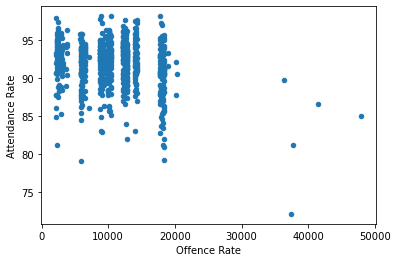

In [11]:
attendance_offences_df.loc[attendance_offences_df['Region'] == 'Central Queensland'].plot.scatter(x='Offence Rate',y='Attendance Rate');

In [12]:
attendance_offences_df['Region'].unique()

array(['Central Queensland', 'North Queensland', 'Metropolitan',
       'North Coast', 'Far North Queensland', 'South East',
       'Darling Downs South West'], dtype=object)

<AxesSubplot:>

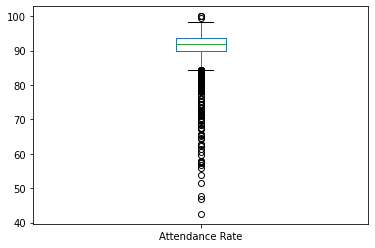

In [25]:
# make deciles for the offences data
attendance_offences_df['quartiles'] = pd.qcut(attendance_offences_df['Offence Rate'],10,labels=False)

In [15]:
#make the box plots for each decile 
deciles = attendance_offences_df['quartiles']


,School Code,School,Attendance Year,School Category,Remoteness Area,Region,Local Government Area,Attendance Rate,Official Low Year Level,Official High Year Level,Post Code,Longitude,Latitude,Offence Rate,quartiles
0,591,Abercorn State School,2015,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),94.5,Prep Year,Year 6,4627,151.127031,-25.135955,14108.0,6
1,591,Abercorn State School,2016,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),95.7,Prep Year,Year 6,4627,151.127031,-25.135955,14081.0,6
2,591,Abercorn State School,2017,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),97.6,Prep Year,Year 6,4627,151.127031,-25.135955,14273.0,6
3,591,Abercorn State School,2018,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),96.5,Prep Year,Year 6,4627,151.127031,-25.135955,13953.0,6
4,591,Abercorn State School,2019,Primary,Outer Regional Australia,Central Queensland,North Burnett (R),95.9,Prep Year,Year 6,4627,151.127031,-25.135955,14202.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6104,275,Zillmere State School,2015,Primary,Major Cities of Australia,Metropolitan,Brisbane (C),91.2,Prep Year,Year 6,4034,153.037355,-27.364673,3795.0,0
6105,275,Zillmere State School,2016,Primary,Major Cities of Australia,Metropolitan,Brisbane (C),91.8,Prep Year,Year 6,4034,153.037355,-27.364673,3942.0,0
6106,275,Zillmere State School,2017,Primary,Major Cities of Australia,Metropolitan,Brisbane (C),90.9,Prep Year,Year 6,4034,153.037355,-27.364673,3904.0,0
6107,275,Zillmere State School,2018,Primary,Major Cities of Australia,Metropolitan,Brisbane (C),88.9,Prep Year,Year 6,4034,153.037355,-27.364673,3986.0,1
